# <a id='env'>1. Setting up the Environment</a>

In [46]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imutils
import glob
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

seed = 2
img_size = (224,224)

# <a id='env'>2. Data Import and Preprocessing</a>

In [2]:
# load data
def load_data(path, img_size=(224,224)):
    img_path = glob.glob(path)
    data = []

    for path in img_path:
        img = cv2.imread(path)
        resized_img = cv2.resize(img, img_size, interpolation=cv2.INTER_CUBIC)
        data.append(resized_img)

    data = np.array(data)
    print(data.shape)
    
    return data

In [3]:
no = load_data("brain-mri-images/original/no/*")
yes = load_data("brain-mri-images/original/yes/*")

(98, 224, 224, 3)
(155, 224, 224, 3)


In [4]:
# save pickle file
def data_to_pickle(data, path, file_name):
    with open(path + file_name + '.pickle', 'wb') as f:
        pickle.dump(no, f, pickle.HIGHEST_PROTOCOL)

In [5]:
data_to_pickle(no, "brain-mri-images/original/", 'no')
data_to_pickle(yes, "brain-mri-images/original/", 'yes')

## data split

In [6]:
def Train_Test_split(data, file_name, train_path='brain-mri-images/train/', test_path='brain-mri-images/test/', seed=42):
    train, test = train_test_split(data, test_size=0.2, random_state=seed)
    save_images(train, train_path+file_name) 
    save_images(test, test_path+file_name) 
        
    return (train, test)

In [7]:
# save images
def save_images(images, path="brain-mri-images/"):
    if not(os.path.isdir(path)):
        os.makedirs(os.path.join(path))

    for i in range(images.shape[0]):
        cv2.imwrite(path + '{0}.png'.format(i), images[i])

In [8]:
no_train, no_test = Train_Test_split(no, 'no/')
yes_train, yes_test = Train_Test_split(yes, 'yes/')

train = np.vstack((no_train, yes_train))
test = np.vstack((no_test, yes_test))

print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (202, 224, 224, 3)
test shape: (51, 224, 224, 3)


In [9]:
data_to_pickle(train, "brain-mri-images/train/", 'train')
data_to_pickle(test, "brain-mri-images/test/", 'test')

## image cropping example

In [10]:
# convert image to grayscale, and blur it slightly
image = yes[0]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

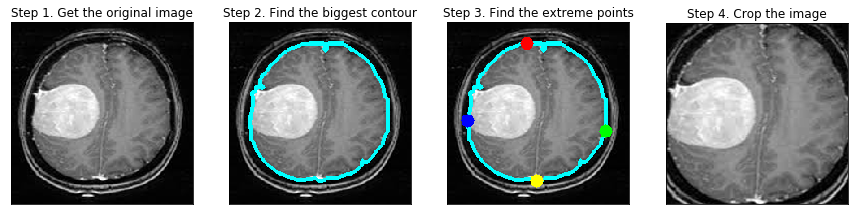

In [11]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(image)
plt.xticks([]); plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([]); plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([]); plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_image)
plt.xticks([]); plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

## image cropping

In [12]:
# cropping
def crop_imgs(images):
    cropped_image = []
    
    for image in images:
        # convert image to grayscale, and blur it slightly
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
        cropped_image.append(new_image)

    return np.array(cropped_image)

In [13]:
cropped_no_train = crop_imgs(no_train)
cropped_no_test = crop_imgs(no_test)
cropped_yes_train = crop_imgs(yes_train)
cropped_yes_test = crop_imgs(yes_test)

In [14]:
save_images(cropped_no_train, "brain-mri-images/cropped/train/no/")
save_images(cropped_no_test, "brain-mri-images/cropped/test/no/")
save_images(cropped_yes_train, "brain-mri-images/cropped/train/yes/")
save_images(cropped_yes_test, "brain-mri-images/cropped/test/yes/")

# <a id='env'>3. data augmentation</a>

## data augmentation example

In [15]:
data_aug_gen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    brightness_range=[0.6, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

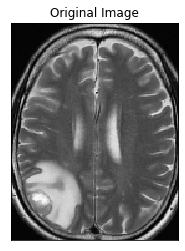

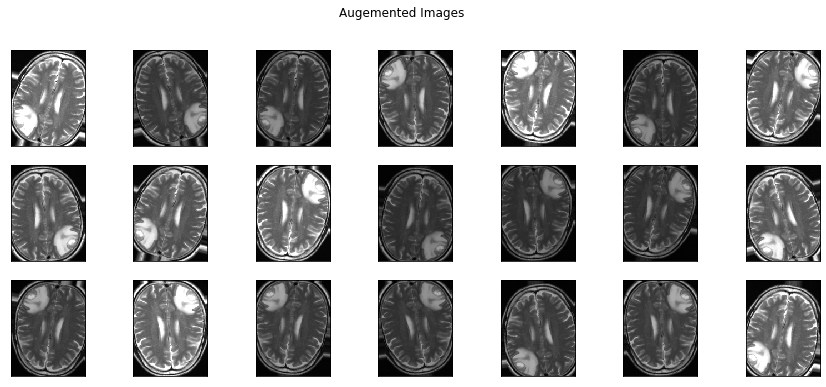

In [16]:
img = cropped_yes_train[0]
plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
x = img.reshape((1,) + img.shape) 
i = 1

os.makedirs(os.path.join('brain-mri-images/augmented/sample/'))

for batch in data_aug_gen.flow(x, batch_size=1, save_to_dir='brain-mri-images/augmented/sample/', save_prefix='yes', save_format='png'):
    plt.subplot(3,7,i)
    batch = batch.reshape(batch.shape[1:])
    plt.imshow(batch)
    plt.xticks([]); plt.yticks([])

    i += 1
    if i > 3*7: 
        break
        
plt.suptitle('Augemented Images')
plt.show()

## data augmentation

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
#    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

In [18]:
train_generator = train_datagen.flow_from_directory(
    'brain-mri-images/cropped/train/',
    color_mode='rgb',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    seed=seed
)

validation_generator = test_datagen.flow_from_directory(
    'brain-mri-images/cropped/test/',
    color_mode='rgb',
    target_size=img_size,
    batch_size=16,
    class_mode='binary',
    seed=seed
)

Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [19]:
data_to_pickle(train_generator, "brain-mri-images/cropped/train/", 'train_generator')
data_to_pickle(validation_generator, "brain-mri-images/cropped/test/", 'validation_generator')

## <a id='build'>4.1. Model Building</a>

In [20]:
# load base model
vgg16_weight_path = '../keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=img_size + (3,)
)

In [21]:
num_class = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_class, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
#    optimizer=RMSprop(lr=1e-4),
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
epochs = 30
callbacks = [EarlyStopping(monitor='val_loss',
                                    patience=6),
             ModelCheckpoint(filepath='model/vgg16_tumor.h5',
                                    monitor='val_loss',
                                    save_best_only=True)]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=callbacks
)

Epoch 1/30
50/50 [==============================] - 334s 7s/step - loss: 0.6969 - accuracy: 0.6072 - val_loss: 0.5138 - val_accuracy: 0.7391
Epoch 2/30
50/50 [==============================] - 334s 7s/step - loss: 0.6161 - accuracy: 0.6812 - val_loss: 0.4174 - val_accuracy: 0.7733
Epoch 3/30
50/50 [==============================] - 328s 7s/step - loss: 0.5721 - accuracy: 0.7061 - val_loss: 0.3607 - val_accuracy: 0.7919
Epoch 4/30
50/50 [==============================] - 324s 6s/step - loss: 0.5015 - accuracy: 0.7503 - val_loss: 0.4374 - val_accuracy: 0.8155
Epoch 5/30
50/50 [==============================] - 336s 7s/step - loss: 0.4856 - accuracy: 0.7628 - val_loss: 0.3750 - val_accuracy: 0.8137
Epoch 6/30
50/50 [==============================] - 352s 7s/step - loss: 0.4719 - accuracy: 0.7732 - val_loss: 0.3941 - val_accuracy: 0.8043
Epoch 7/30
50/50 [==============================] - 359s 7s/step - loss: 0.4433 - accuracy: 0.7932 - val_loss: 0.3157 - val_accuracy: 0.8354
Epoch 8/30
50

## <a id='perf'>4.2. Training History</a>

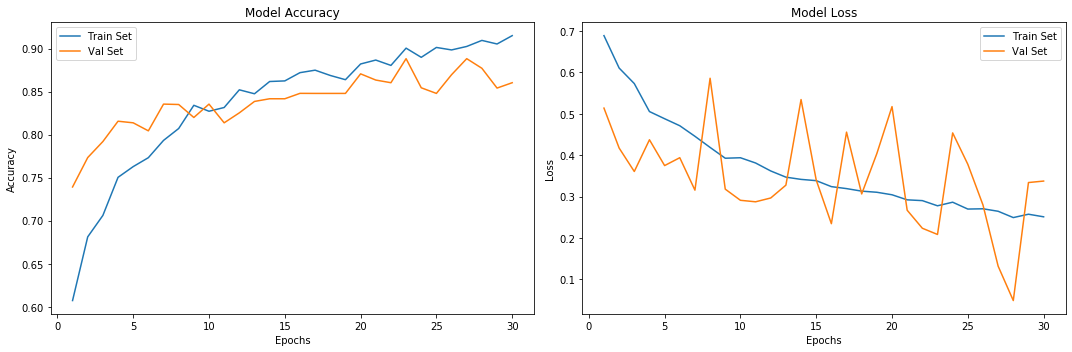

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## <a id='perf'>4.3. Model Performance</a>

In [73]:
pred = model.predict(test)
pred = [1 if x>0.5 else 0 for x in pred]

acc = accuracy_score(validation_generator.labels, pred)
print('Val Accuracy = %.3f' % acc)

Val Accuracy = 0.804


### Confusion Matrix

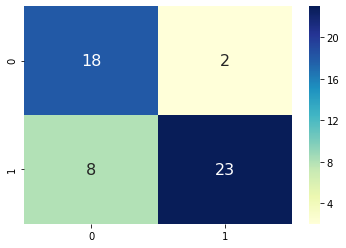

In [74]:
confusion_mtx = confusion_matrix(validation_generator.labels, pred) 
ax = sns.heatmap(confusion_mtx, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")

### check missclassified images

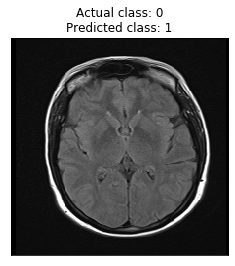

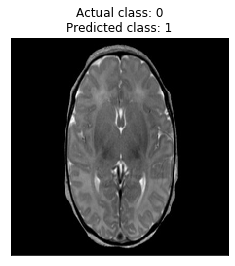

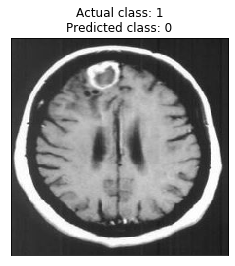

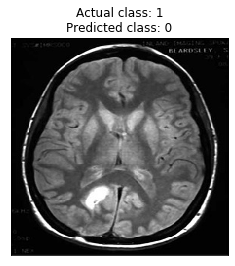

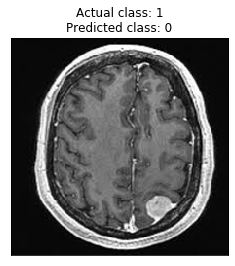

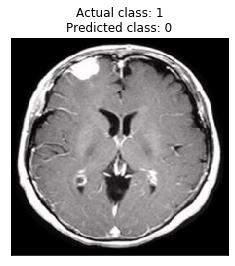

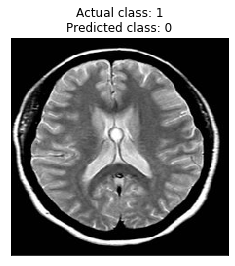

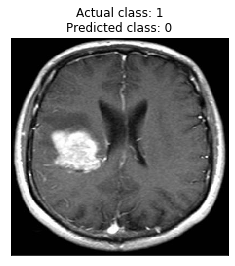

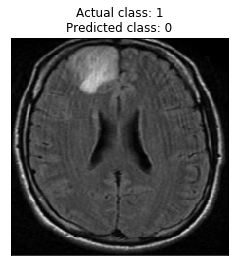

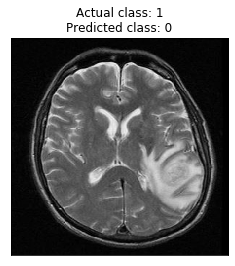

In [75]:
ind_list = np.argwhere((validation_generator.labels == pred) == False)[:, -1]

if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(test[i])
        plt.xticks([]); plt.yticks([])
        plt.title(f'Actual class: {validation_generator.labels[i]}\nPredicted class: {pred[i]}')
        plt.show()

# <a id='concl'>5. Conclusions</a>

**그래도 80%는 넘어간다.**

In [76]:
model.save('model/2020-03-06_VGG_model.h5')